# Develop detection of synchronization artifacts
using drop and spike detection, as well as channel selection

In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages', '/Users/lenasalzmann/dev/dbs-eeg-sync']


In [2]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import plotly.graph_objects as go

In [3]:
from dbs_eeg_sync.power_calculator import compute_samplewise_eeg_power

In [4]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
sub_ids = ['P4-2007']
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"

# Function for eeg sync artifact detection

In [5]:
def detect_eeg_change_window(
    eeg_power,
    eeg_fs,
    smooth_window=301,
    window_size_sec=2,
    plot=False,
    save_dir=None
):

    smoothed = savgol_filter(eeg_power, window_length=smooth_window, polyorder=3)
    window_size = int(window_size_sec * eeg_fs)

    min_diff = np.inf
    max_diff = -np.inf
    drop_onset_idx = None
    spike_onset_idx = None

    for i in range(0, len(smoothed) - 2 * window_size):
        pre = smoothed[i : i + window_size]
        post = smoothed[i + window_size : i + 2 * window_size]
        diff = np.mean(post) - np.mean(pre)

        if diff < min_diff:
            min_diff = diff
            drop_onset_idx = i + window_size

        if diff > max_diff:
            max_diff = diff
            spike_onset_idx = i + window_size

    # Pick steeper one
    if abs(min_diff) >= abs(max_diff):
        result = {
            "type": "drop",
            "index": drop_onset_idx,
            "time": drop_onset_idx / eeg_fs if drop_onset_idx else None,
            "magnitude": min_diff,
        }
    else:
        result = {
            "type": "spike",
            "index": spike_onset_idx,
            "time": spike_onset_idx / eeg_fs if spike_onset_idx else None,
            "magnitude": max_diff,
        }

    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=smoothed, mode="lines", name="Smoothed Power"))
        fig.add_vline(
            x=result["index"], 
            line=dict(color="red" if result["type"] == "drop" else "green", dash="dash")
        )
        fig.update_layout(title="EEG Change Detection (Steepest)", xaxis_title="Samples", yaxis_title="Power")
        fig.show()

        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            fig.write_image(os.path.join(save_dir, "change_onset_detection_steepest.png"))

    return result, smoothed

## Detect change 

In [6]:
# loop through subjects

for sub_id in sub_ids:

    print(f"---\nProcessing subject {sub_id} for block {block}...")
    # eeglab_file_path_components = [dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set']
    eeglab_file_path_components = [dataDir_server, sub_id, 'RawData', 'EEG', block, block + '_raw.set']
    eeglab_file_path = os.path.join(*eeglab_file_path_components)
    # check if the file exists, if not, skip the subject
    if not os.path.exists(eeglab_file_path):
        print(f"---\nSkipping subject {sub_id} for block {block} as the file {eeglab_file_path} does not exist.")
        continue
    #  Load the EEG data
    raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
    eeg_fs = raw.info['sfreq']

    # if subject is not P4-2006, use the default frequency range
    if sub_id == 'P4-2007':
        freq_low, freq_high = 110, 120
        
    else:   
        freq_low, freq_high = 120, 130

    eeg_power, power_time_axis = compute_samplewise_eeg_power(raw, freq_low, freq_high, channel="CPz")
    
    result, smoothed = detect_eeg_change_window(eeg_power, eeg_fs=eeg_fs, smooth_window=301, window_size_sec=4, plot=True)
result

---
Processing subject P4-2007 for block baseline...


{'type': 'drop',
 'index': 2187,
 'time': 8.748,
 'magnitude': np.float64(-1.1230955801611084e-12)}

Function for power plotting and channel selection


Processing P4-2012...
Error processing Oz: picks ('Oz') could not be interpreted as channel names (no channel "[np.str_('Oz')]"), channel types (no type "Oz" present), or a generic type (just "all" or "data")


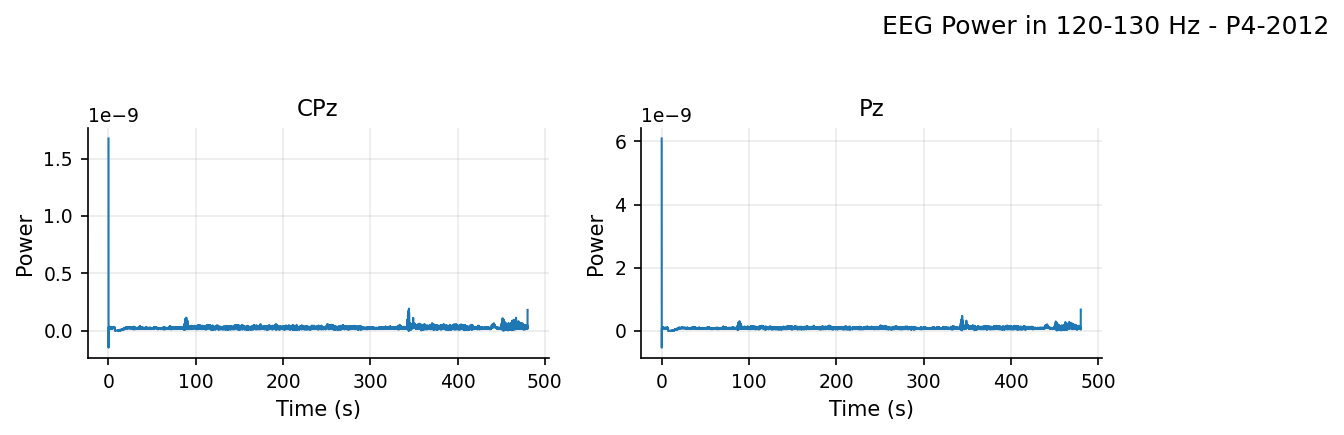

🔎 P4-2012 - Selected Channel: Pz
    Type: spike, Magnitude: 0.000, Time: 342.54s


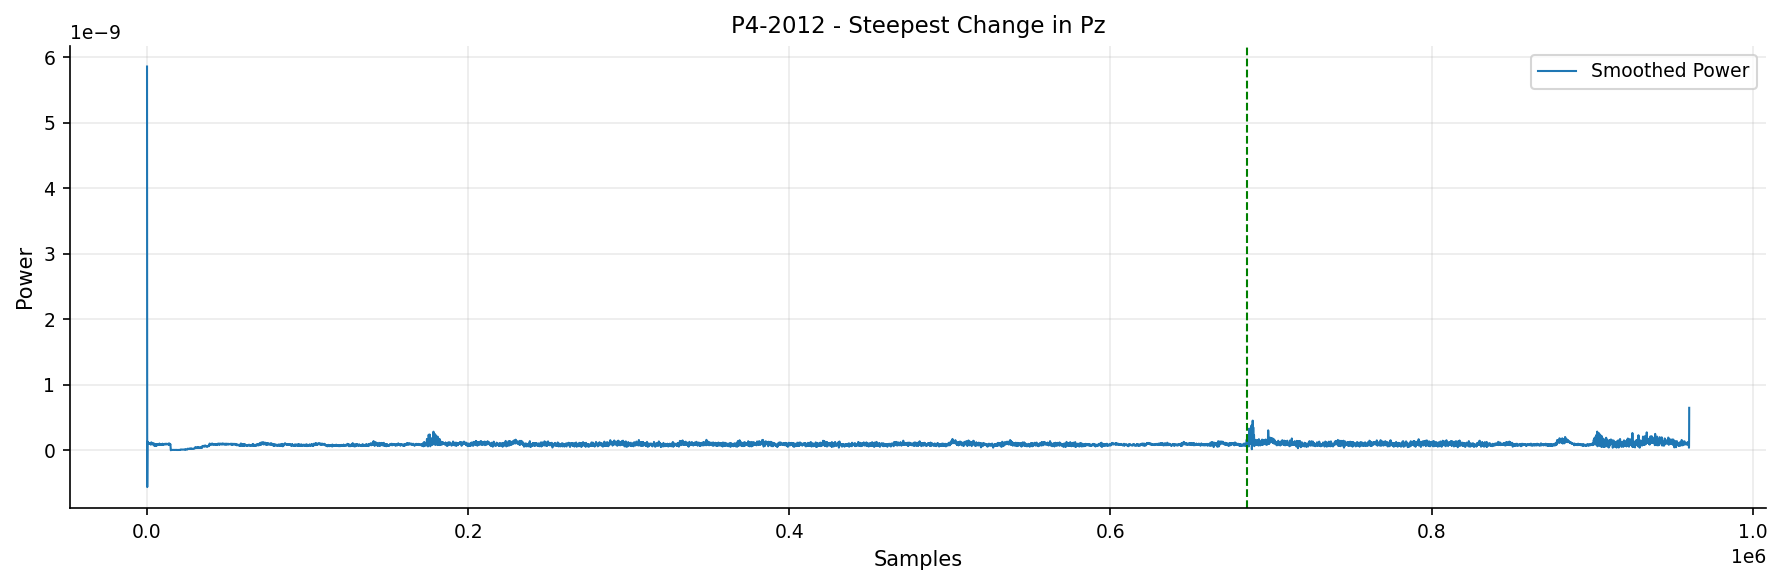

In [7]:
def plot_power_grid_and_select_channel(sub_ids, block, dataDir_server):
    from scipy.signal import savgol_filter

    for sub_id in sub_ids:
        print(f"\nProcessing {sub_id}...")
        eeglab_file_path = os.path.join(
            dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set'
        )
        if not os.path.exists(eeglab_file_path):
            print(f"Skipping {sub_id}, file not found.")
            continue

        eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
        if sub_id == 'P4-2007':
            freq_low, freq_high = 110, 120
        else:
            freq_low, freq_high = 120, 130

        eeg_channel_names = eeg_raw.ch_names

        # select channels of interest
        eeg_channel_names = ['CPz', 'Pz', 'Oz']
        n_channels = len(eeg_channel_names)
        n_cols = 4
        n_rows = int(np.ceil(n_channels / n_cols))

        plt.figure(figsize=(15, n_rows * 3))

        best_channel = None
        best_magnitude = 0
        best_result = None
        best_smoothed = None

        for i, ch in enumerate(eeg_channel_names):
            try:
                eeg_power, time_axis = compute_samplewise_eeg_power(
                    eeg_raw, freq_low, freq_high, channel=ch
                )
            except Exception as e:
                print(f"Error processing {ch}: {e}")
                continue

            # Plotting
            plt.subplot(n_rows, n_cols, i + 1)
            plt.plot(time_axis, eeg_power)
            plt.title(ch)
            plt.xlabel('Time (s)')
            plt.ylabel('Power')

            # Detect drop/spike
            result, smoothed = detect_eeg_change_window(
                eeg_power,
                eeg_fs=int(eeg_raw.info['sfreq']),
                plot=False
            )
            if result and abs(result["magnitude"]) > best_magnitude:
                best_channel = ch
                best_magnitude = abs(result["magnitude"])
                best_result = result
                best_smoothed = smoothed

        plt.suptitle(f"EEG Power in {freq_low}-{freq_high} Hz - {sub_id}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # --- Report ---
        if best_channel:
            print(f"🔎 {sub_id} - Selected Channel: {best_channel}")
            print(f"    Type: {best_result['type']}, Magnitude: {best_result['magnitude']:.3f}, Time: {best_result['time']:.2f}s")

            # Optional: plot detection result
            plt.figure(figsize=(12, 4))
            plt.plot(best_smoothed, label="Smoothed Power")
            plt.axvline(best_result["index"], color="red" if best_result["type"] == "drop" else "green", linestyle="--")
            plt.title(f"{sub_id} - Steepest Change in {best_channel}")
            plt.xlabel("Samples")
            plt.ylabel("Power")
            plt.legend()
            plt.show()

# Example usage
# sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
sub_ids = ['P4-2012']
block = 'pre8walk'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"
plot_power_grid_and_select_channel(sub_ids, block, dataDir_server)

In [8]:
def plot_power_grid(sub_id, block, dataDir_server):
    eeglab_file_path = os.path.join(
        dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set'
    )
    eeg_raw = mne.io.read_raw_eeglab(eeglab_file_path, preload=True)
    freq_low, freq_high = (110, 120) if sub_id == 'P4-2007' else (120, 130)

    eeg_channel_names = [ch for ch in eeg_raw.ch_names if 'EEG' in ch]
    n_channels = len(eeg_channel_names)
    n_cols = 4
    n_rows = int(np.ceil(n_channels / n_cols))

    plt.figure(figsize=(15, n_rows * 3))
    for i, ch in enumerate(eeg_channel_names):
        eeg_power, time_axis = compute_samplewise_eeg_power(
            eeg_raw, freq_low, freq_high, channel=ch
        )
        plt.subplot(n_rows, n_cols, i + 1)
        plt.plot(time_axis, eeg_power)
        plt.title(ch)
        plt.xlabel('Time (s)')
        plt.ylabel('Power')
    plt.suptitle(f"EEG Power {freq_low}-{freq_high} Hz - {sub_id}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()